# openEO Demonstration

## Setup

In [1]:
import os
import openeo
import json
import xarray
import matplotlib.pyplot as pyplot
from IPython.display import display, Markdown

import sys
sys.path.append('../')
from modules.helpers import get_access_token, load_eoepca_state, test_cell, test_results

Load `eoepca state` environment

In [2]:
load_eoepca_state()

In [3]:
platform_domain = os.environ.get("INGRESS_HOST")

openeo_backend = f"openeo.{platform_domain}"
authentication_method = "device-code-flow" # or authorization-code

username = os.environ.get("KEYCLOAK_TEST_USER")
password = os.environ.get("KEYCLOAK_TEST_PASSWORD")
client_id = os.environ.get("OPENEO_CLIENT_ID")

collection_id = "TestCollection-LonLat16x16"
temporal_extent = "2024-09"
spatial_extent = {"west": 3, "south": 51, "east": 5, "north": 53}

log_output_file = "openeo_log.json"

In [4]:
print(f"Parameters:\n"
f"Platform domain: {platform_domain}\n"
f"OpenEO backend: {openeo_backend}\n"
f"Authentication method: {authentication_method}\n"
f"Collection ID: {collection_id}\n"
f"Temporal extent: {temporal_extent}\n"
f"Spatial extent: {spatial_extent}")

Parameters:
Platform domain: test.eoepca.org
OpenEO backend: openeo.test.eoepca.org
Authentication method: device-code-flow
Collection ID: TestCollection-LonLat16x16
Temporal extent: 2024-09
Spatial extent: {'west': 3, 'south': 51, 'east': 5, 'north': 53}


## Connect to the openEO backend

In [6]:
connection = openeo.connect(url=openeo_backend)
if authentication_method == "device-code-flow":
    connection.authenticate_oidc()
    markdown = (
        "### openEO Web Editor\n\n"
        "Using the `device-code-flow` you can use the **openEO Web Editor** to connect to the openEO instance:\n"
        f"- Open the URL: {connection.web_editor(anonymous=True)}\n"
        "- Select to `Login`\n"
        "- Select `Log in with EOEPCA` - which should redirect to the EOEPCA Keycloak instance\n"
        "- Login with a suitable Keycloak account - for example the `eoepcauser` sample user\n\n"
        "**After successful login the openEO Web Editor is connected as a client to the EOEPCA openEO backend**"
    )
    # markdown = f"### openEO Web Editor\nUsing the `device-code-flow` you can use the openEO Web Editor to connect to the openEO instance.<br>Open the URL: {connection.web_editor(anonymous=True)}"
    display(Markdown(markdown))
elif authentication_method == "authorization-code":
    access_token = get_access_token(username, password, client_id)
    auth_token = f"oidc/eoepca/{access_token}"
    connection.session.headers.update({"Authorization": f"Bearer {auth_token}"})

Authenticated using refresh token.


### openEO Web Editor

Using the `device-code-flow` you can use the **openEO Web Editor** to connect to the openEO instance:
- Open the URL: https://editor.openeo.org/?server=https%3A%2F%2Fopeneo.test.eoepca.org%2Fopeneo%2F1.2%2F&discover=1
- Select to `Login`
- Select `Log in with EOEPCA` - which should redirect to the EOEPCA Keycloak instance
- Login with a suitable Keycloak account - for example the `eoepcauser` sample user

**After successful login the openEO Web Editor is connected as a client to the EOEPCA openEO backend**

## Exploration

Available collections:

In [7]:
# collection_exists
available_collections = connection.list_collection_ids()
print(f"Available collections: {available_collections}")
assert collection_id in available_collections

Available collections: ['TestCollection-LonLat16x16']


Available processes:

In [8]:
# list_processes
[p["id"] for p in connection.list_processes()[:10]]

['arccos',
 'arcosh',
 'power',
 'last',
 'subtract',
 'not',
 'cosh',
 'artanh',
 'is_valid',
 'first']

## Simple processing

In [9]:
# process_execution
process_graph = {
    "add": {
        "process_id": "add",
        "arguments": {"x": 3, "y": 5},
        "result": True,
    },
}

result = connection.execute(process_graph)
result

8

## Raster processing

Raster processing with built-in dummy collection (which does not require direct access to actual EO data).

In [10]:
# data_loading
cube = connection.load_collection(
    collection_id=collection_id,
    temporal_extent=temporal_extent,
    spatial_extent=spatial_extent,
    bands=["Longitude", "Latitude", "Day"],
)

In [11]:
%%time
cube.download("openeo-lonlat1616.nc")

CPU times: user 3.88 ms, sys: 3.95 ms, total: 7.83 ms
Wall time: 13.5 s


Inspect downloaded results:

In [12]:
# raster_download
ds = xarray.load_dataset("openeo-lonlat1616.nc")
ds

<xarray.Dataset> Size: 74kB
Dimensions:    (t: 3, x: 32, y: 32)
Coordinates:
  * t          (t) datetime64[ns] 24B 2024-09-05 2024-09-15 2024-09-25
  * x          (x) float64 256B 3.031 3.094 3.156 3.219 ... 4.844 4.906 4.969
  * y          (y) float64 256B 52.97 52.91 52.84 52.78 ... 51.16 51.09 51.03
Data variables:
    crs        |S1 1B b''
    Longitude  (t, y, x) float64 25kB 3.0 3.062 3.125 ... 4.812 4.875 4.938
    Latitude   (t, y, x) float64 25kB 52.94 52.94 52.94 52.94 ... 51.0 51.0 51.0
    Day        (t, y, x) float64 25kB 5.0 5.0 5.0 5.0 ... 25.0 25.0 25.0 25.0
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

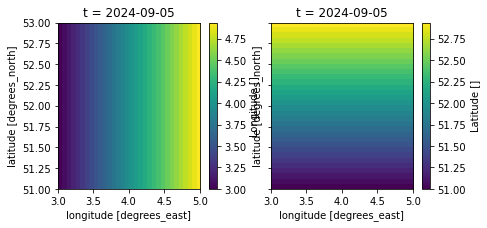

In [13]:
fig, axes = pyplot.subplots(ncols=2, figsize=(7, 3), dpi=72, sharey=True)

ds["Longitude"].isel(t=0).plot.imshow(ax=axes[0])
ds["Latitude"].isel(t=0).plot.imshow(ax=axes[1]);

## Real raster processing with `load_stac`

`load_stac` is an standard openEO process that allows to load EO data that is hosted externally through the STAC standard.

In [14]:
# raster_open
stac_url = "https://raw.githubusercontent.com/Open-EO/openeo-geopyspark-driver/refs/heads/master/docker/local_batch_job/example_stac_catalog/collection.json"

cube = connection.load_stac(
    url=stac_url,
    temporal_extent=["2023-06-01", "2023-06-09"],
    spatial_extent={"west": 5.07, "south": 51.215, "east": 5.08, "north": 51.22},
    bands=["B04", "B03", "B02"],
)
cube

bands_from_stac_collection: consulting items for band metadata
Using 'eo:bands' metadata, but STAC extension eo was not declared.


Simple "band math" based processing, to calculate some NDVI-like index:

In [15]:
# band_math
b04 = cube.band("B04")
b02 = cube.band("B02")
n42 = (b04 - b02) / (b04 + b02)

Trigger processing and download result synchronously:

In [16]:
# nc_download
n42.download("openeo-load_stac-n42-sync.nc")

Inspect result:

In [17]:
# xarray_load_dataset
ds = xarray.load_dataset("openeo-load_stac-n42-sync.nc")
ds

<xarray.Dataset> Size: 52kB
Dimensions:  (t: 3, x: 73, y: 58)
Coordinates:
  * t        (t) datetime64[ns] 24B 2023-06-01 2023-06-04 2023-06-06
  * x        (x) float64 584B 6.446e+05 6.446e+05 ... 6.453e+05 6.453e+05
  * y        (y) float64 464B 5.676e+06 5.676e+06 ... 5.676e+06 5.676e+06
Data variables:
    crs      |S1 1B b''
    var      (t, y, x) float32 51kB 0.2153 0.2179 0.227 ... -0.03759 -0.1307
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

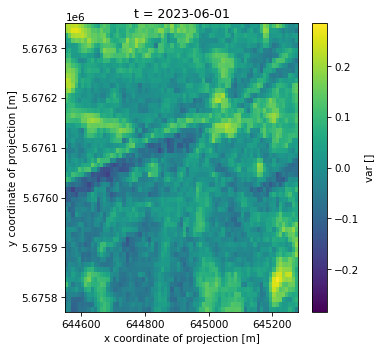

In [18]:
# plot_figure
fig, ax = pyplot.subplots(dpi=75, figsize=(5, 5))

ds["var"].isel(t=0).plot.imshow(ax=ax, cmap="viridis");

In [19]:
if test_results:
    for test, result in test_results.items():
        print(f"{test}: {result['status']} - {result['message']}")
    json.dump(test_results, open(log_output_file, "w"), indent=2)